In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import ast
import pickle
import optuna
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pp

Most of this code comes from Googles Training course on text classification:  https://developers.google.com/machine-learning/guides/text-classification.  This has been adapted and improved to include k-folds cross validation to produce a more consistent result in training given that the volume of training data is low.

### Step 1 - Import Train and Test Data and convert to required data type

In [3]:
# Load training set from CSV, convert CSV text to list and join into a single string
train_data = pd.read_csv("train_data.csv")
train_data['preprocessed_text'] = train_data['preprocessed_text'].apply(ast.literal_eval)
train_data['preprocessed_text'] = train_data['preprocessed_text'].apply(' '.join)
train_texts = train_data['preprocessed_text'].to_numpy()

# Load test set from CSV, convert CSV text to list and join into a single string
test_data = pd.read_csv("test_data.csv")
test_data['preprocessed_text'] = test_data['preprocessed_text'].apply(ast.literal_eval)
test_data['preprocessed_text'] = test_data['preprocessed_text'].apply(' '.join)
test_texts = test_data['preprocessed_text'].to_numpy()


In [14]:
# Create dictionary of integer values for the labels so we can convert back at a later dat
def create_label_dict(df, col_name):
    unique_values = df[col_name].unique()
    value_dict = {value: i for i, value in enumerate(unique_values)}
    return value_dict

label_dict = create_label_dict(train_data, 'clause_type')

# convert existing text labels to integers 1-10 using dictionary
def transform_column(df, col_name, mapping_dict):
    return df[col_name].map(mapping_dict).values.astype(np.int64)

train_labels = transform_column(train_data, 'clause_type', label_dict)
test_labels = transform_column(test_data, 'clause_type', label_dict)


### Step 2 - Functions for Vectorisation

In [5]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000
# Whether text should be split into word or character n-grams. One of 'word', 'char'.
TOKEN_MODE = 'word'
# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(x_train_fold, y_train_fold, x_val_fold,**kwargs):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        x_train_fold: list, training text strings.
        y_train_fold: np.ndarray, training labels (integers).
        x_val_fold: list, validation text strings.

    # Returns
        x_train: vectorized training texts
        x_val: vectorized validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
        'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,  # Split text into word tokens.
        'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train_fold = vectorizer.fit_transform(x_train_fold).astype(np.float32)  # Fixed variable name

    # Vectorize validation texts.
    x_val_fold = vectorizer.transform(x_val_fold).astype(np.float32)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train_fold.shape[1]))
    selector.fit(x_train_fold, y_train_fold)
    x_train = selector.transform(x_train_fold).astype('float32')
    x_val = selector.transform(x_val_fold).astype('float32')
    
    # Save vectorizer and selector to disk for future use
    with open('vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

    with open('selector.pkl', 'wb') as f:
        pickle.dump(selector, f)
    
    # Return both the vectorized texts
    return x_train, x_val

In [6]:
def vectorize_production_data(prod_texts,**kwargs):
    """Vectorizes new production texts using the pre-trained vectorizer and selector.

    # Arguments
        prod_texts: list, new production text strings.

    # Returns
        x_prod: vectorized production texts.
    """

    # Load the saved vectorizer and feature selector
    with open('vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    with open('selector.pkl', 'rb') as f:
        selector = pickle.load(f)

    # Vectorize production texts using the trained vectorizer
    x_prod = vectorizer.transform(prod_texts).astype(np.float32)

    # Apply feature selection using the trained selector
    x_prod = selector.transform(x_prod).astype(np.float32)

    return x_prod

### Step 3 - Define Function to create last layer according to data parameters

In [7]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.
    # Arguments
        num_classes: int, number of classes.
    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

### Step 4 - Define function to build simple multi-layer perceptron  

In [8]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Define the input shape using Input layer
    model.add(Input(shape=input_shape))

    # Add the first Dense layer (input layer) without Dropout yet
    model.add(Dense(units=units, activation='relu'))

    # Add Dropout and subsequent layers
    for _ in range(layers - 1):
        model.add(Dropout(rate=dropout_rate))  # Add Dropout after Dense layers
        model.add(Dense(units=units, activation='relu'))

    # Output layer
    model.add(Dense(units=op_units, activation=op_activation))

    return model

### Step 5 - Create a function to train the n_gram model

In [9]:
# train model with kfolds validation
def train_ngram_model_kfolds(data,k=5,
                            learning_rate=1e-3,
                            epochs=1000,
                            batch_size=128,
                            layers=2,
                            units=64,
                            dropout_rate=0.2,
                            num_classes=10,
                            **kwargs):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        """Trains n-gram model on the given dataset.
    
        # Arguments
            k: no of folds 
            data: tuples of training and test texts and labels.
            learning_rate: float, learning rate for training model.
            epochs: int, number of epochs.
            batch_size: int, number of samples per batch.
            layers: int, number of `Dense` layers in the model.
            units: int, output dimension of Dense layers in the model.
            dropout_rate: float: percentage of input to drop at Dropout layers.
            num_classes: int, number of output classes.
        """
        # Get the data.
        train_texts, train_labels = data
        
        # Prepare k-fold cross-validation
        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        
        # Store validation results for each fold
        val_accuracies = []
        val_losses = []
    
        # Perform K-Fold Cross-Validation
        for train_idx, val_idx in kfold.split(train_texts):
            # Split data into training and validation for this fold
            # K-fold cross-validation
            x_train_fold = train_texts[train_idx]
            y_train_fold = train_labels[train_idx]
            x_val_fold = train_texts[val_idx]
            y_val_fold = train_labels[val_idx]
            
           # Vectorize texts.
            x_train, x_val = ngram_vectorize(x_train_fold, y_train_fold, x_val_fold,**kwargs)             
            
            # Check for empty tensors
            if x_train.shape[0] == 0:
                print("Training data tensor is empty")
                print("kwargs:")
                for key, value in kwargs.items():
                    print(f"{key}: {value}")
            if x_val.shape[0] == 0:
                print("Validation data tensor is empty")
                print("kwargs:")
                for key, value in kwargs.items():
                    print(f"{key}: {value}")
            
            # Create model instance.
            model = mlp_model(layers=layers,
                              units=units,
                              dropout_rate=dropout_rate,
                              input_shape=x_train.shape[1:],
                              num_classes=num_classes)
            
            loss = 'sparse_categorical_crossentropy'
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        
            # Create callback for early stopping on validation loss. If the loss does not decrease in two consecutive tries, stop training.
            callbacks = [EarlyStopping(monitor='val_loss', patience=2)]
            
            # Train and validate the model on this fold
            history = model.fit(
                x_train,
                y_train_fold,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=(x_val, y_val_fold),
                verbose=0,
                batch_size=batch_size
            )
            # Collect the last validation accuracy and loss
            history = history.history
            val_accuracies.append(history['val_accuracy'][-1])
            val_losses.append(history['val_loss'][-1])
        
        # Compute average validation accuracy and loss
        avg_val_accuracy = np.mean(val_accuracies)
        avg_val_loss = np.mean(val_losses)
        
        # Print results.
        print('Average Validation Accuracy: {:.4f}, Average Loss: {:.4f}'.format(avg_val_accuracy, avg_val_loss))
    
        # Save model.
        model.save('Clause_class_model.keras')
        
    return avg_val_accuracy, avg_val_loss

### Step 6 - Build Model and train model

In [10]:
data = (train_texts, train_labels)
train_ngram_model_kfolds(data)

Average Validation Accuracy: 0.8679, Average Loss: 0.3902


(0.8678576231002808, 0.3901568830013275)

### Step 7 - Make predictions on test data prior to Hyperparameter Optimisation

In [11]:
# Vectorize the production data using the previously defined function
x_prod = vectorize_production_data(test_texts)

# Make predictions on the production data using the trained model
model = load_model('Clause_class_model.keras')
predictions = model.predict(x_prod)

# Step 3: Convert predicted probabilities to class labels. N.B. Its argmax because you get a softmax output so you want the most probab;y class
predicted_classes = np.argmax(predictions, axis=1)

# Step 4: Calculate accuracy by comparing predicted classes with true labels
accuracy = accuracy_score(test_labels, predicted_classes)

# Step 5: Output the accuracy
print(f"Accuracy on test data: {accuracy:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy on test data: 0.8903


### Step 8 - Tune Hyperparameters

In [16]:
def objective(trial):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        data = (train_texts, train_labels)
        # Define the hyperparameters to optimize
        learning_rate = trial.suggest_float("learning_rate", 1e-5,1e-1)
        layers = trial.suggest_int("layers", 2, 6)
        units = trial.suggest_categorical("units", [64,128])
        dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
        NGRAM_RANGE = trial.suggest_categorical('N_GRAM_RANGE', [(1, 1), (1, 2), (2, 2),(1, 3),(2, 3),(3, 3),(1, 4),(2, 4),(3, 4),(4, 4)])  
        TOP_K = trial.suggest_int("TOP_K",10000,40000)
        MIN_DOCUMENT_FREQUENCY = trial.suggest_int("MIN_DOCUMENT_FREQUENCY", 1, 2)
            
        # Call the train_ngram_model_kfolds function with the sampled hyperparameters
        avg_val_accuracy, avg_val_loss = train_ngram_model_kfolds(data, learning_rate=learning_rate,layers=layers,units=units,dropout_rate=dropout_rate,num_classes=10, NGRAM_RANGE=NGRAM_RANGE,TOP_K=TOP_K, MIN_DOCUMENT_FREQUENCY=MIN_DOCUMENT_FREQUENCY)

    # Since Optuna minimizes the objective, we may want to minimize -accuracy if maximizing accuracy
    return avg_val_accuracy  # Maximize accuracy by minimizing negative accuracy

# Create an Optuna study to optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print the best result
print("Best value:", study.best_value)
print("Best parameters:", study.best_params)

[I 2024-09-22 20:38:28,394] A new study created in memory with name: no-name-3e58f3d2-7181-4332-ad21-cfd0290b9e9b
[I 2024-09-22 20:38:34,623] Trial 0 finished with value: 0.862898302078247 and parameters: {'learning_rate': 0.01819183800107648, 'layers': 2, 'units': 128, 'dropout_rate': 0.44704539127666726, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 29311, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8629, Average Loss: 0.5415


[I 2024-09-22 20:38:43,020] Trial 1 finished with value: 0.6916774034500122 and parameters: {'learning_rate': 0.06955646357038357, 'layers': 4, 'units': 64, 'dropout_rate': 0.36596654979199195, 'N_GRAM_RANGE': (4, 4), 'TOP_K': 26933, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.6917, Average Loss: 0.7249


[I 2024-09-22 20:38:51,946] Trial 2 finished with value: 0.10919947028160096 and parameters: {'learning_rate': 0.06038854030200841, 'layers': 6, 'units': 128, 'dropout_rate': 0.4806182562657614, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 15840, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.1092, Average Loss: 2.3060


[I 2024-09-22 20:39:00,174] Trial 3 finished with value: 0.622762143611908 and parameters: {'learning_rate': 0.09688212244214486, 'layers': 3, 'units': 128, 'dropout_rate': 0.4358240396041656, 'N_GRAM_RANGE': (3, 4), 'TOP_K': 36171, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.6228, Average Loss: 1.0064


[I 2024-09-22 20:39:08,932] Trial 4 finished with value: 0.8349614620208741 and parameters: {'learning_rate': 0.011291325388091336, 'layers': 5, 'units': 64, 'dropout_rate': 0.3834435215587111, 'N_GRAM_RANGE': (4, 4), 'TOP_K': 39311, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8350, Average Loss: 0.4234


[I 2024-09-22 20:39:15,956] Trial 5 finished with value: 0.8616637587547302 and parameters: {'learning_rate': 0.034942094480664584, 'layers': 3, 'units': 64, 'dropout_rate': 0.46911186938579563, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 23812, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8617, Average Loss: 0.4238


[I 2024-09-22 20:39:25,913] Trial 6 finished with value: 0.8486241221427917 and parameters: {'learning_rate': 0.004405119267240801, 'layers': 6, 'units': 128, 'dropout_rate': 0.310483843944406, 'N_GRAM_RANGE': (1, 3), 'TOP_K': 22142, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8486, Average Loss: 0.5342


[I 2024-09-22 20:39:33,743] Trial 7 finished with value: 0.3262734889984131 and parameters: {'learning_rate': 0.07779318151304858, 'layers': 5, 'units': 64, 'dropout_rate': 0.3564519233975299, 'N_GRAM_RANGE': (3, 4), 'TOP_K': 36787, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.3263, Average Loss: 1.6459


[I 2024-09-22 20:39:38,491] Trial 8 finished with value: 0.8591658115386963 and parameters: {'learning_rate': 0.021370301655376792, 'layers': 2, 'units': 64, 'dropout_rate': 0.3349133712411162, 'N_GRAM_RANGE': (1, 2), 'TOP_K': 24303, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8592, Average Loss: 0.6459


[I 2024-09-22 20:39:46,102] Trial 9 finished with value: 0.8374651312828064 and parameters: {'learning_rate': 0.02907934380530218, 'layers': 4, 'units': 128, 'dropout_rate': 0.3203042099258885, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 36684, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8375, Average Loss: 0.5866


[I 2024-09-22 20:39:51,707] Trial 10 finished with value: 0.8566928744316101 and parameters: {'learning_rate': 0.04582553759450877, 'layers': 2, 'units': 128, 'dropout_rate': 0.23608842383643477, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 30641, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8567, Average Loss: 0.6487


[I 2024-09-22 20:39:58,846] Trial 11 finished with value: 0.8554641127586364 and parameters: {'learning_rate': 0.03951783621992877, 'layers': 3, 'units': 64, 'dropout_rate': 0.48494116447647495, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 18151, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8555, Average Loss: 0.4502


[I 2024-09-22 20:40:05,508] Trial 12 finished with value: 0.8517354846000671 and parameters: {'learning_rate': 0.024625333787746534, 'layers': 3, 'units': 128, 'dropout_rate': 0.42820529697042453, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 10180, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8517, Average Loss: 0.6037


[I 2024-09-22 20:40:19,223] Trial 13 finished with value: 0.8585562229156494 and parameters: {'learning_rate': 0.035580033831355065, 'layers': 2, 'units': 64, 'dropout_rate': 0.4353120255363541, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 30581, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 0 with value: 0.862898302078247.


Average Validation Accuracy: 0.8586, Average Loss: 0.5992


[I 2024-09-22 20:41:15,545] Trial 14 finished with value: 0.871586263179779 and parameters: {'learning_rate': 9.757106529233173e-05, 'layers': 3, 'units': 64, 'dropout_rate': 0.4895316780657995, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 29168, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8716, Average Loss: 0.3601


[I 2024-09-22 20:41:21,778] Trial 15 finished with value: 0.863530957698822 and parameters: {'learning_rate': 0.005937172297266181, 'layers': 2, 'units': 128, 'dropout_rate': 0.4157361580650333, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 29944, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8635, Average Loss: 0.4721


[I 2024-09-22 20:41:34,918] Trial 16 finished with value: 0.8703536272048951 and parameters: {'learning_rate': 0.0006278767142968121, 'layers': 3, 'units': 64, 'dropout_rate': 0.3964121663616701, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33061, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8704, Average Loss: 0.3728


[I 2024-09-22 20:41:54,642] Trial 17 finished with value: 0.868480670452118 and parameters: {'learning_rate': 0.00023819479375840108, 'layers': 4, 'units': 64, 'dropout_rate': 0.27079209300942386, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33354, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8685, Average Loss: 0.3702


[I 2024-09-22 20:42:00,484] Trial 18 finished with value: 0.8672499656677246 and parameters: {'learning_rate': 0.013955797409660896, 'layers': 3, 'units': 64, 'dropout_rate': 0.3897566376995311, 'N_GRAM_RANGE': (2, 2), 'TOP_K': 33070, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8672, Average Loss: 0.4781


[I 2024-09-22 20:42:08,080] Trial 19 finished with value: 0.38345672488212584 and parameters: {'learning_rate': 0.05188308266228695, 'layers': 5, 'units': 64, 'dropout_rate': 0.49750018366468673, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 20461, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.3835, Average Loss: 1.5712


[I 2024-09-22 20:42:15,914] Trial 20 finished with value: 0.5689575672149658 and parameters: {'learning_rate': 0.0894939733184375, 'layers': 4, 'units': 64, 'dropout_rate': 0.40126651523081486, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 26803, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.5690, Average Loss: 1.2587


[I 2024-09-22 20:42:23,645] Trial 21 finished with value: 0.8610406994819642 and parameters: {'learning_rate': 0.0023491934336609985, 'layers': 4, 'units': 64, 'dropout_rate': 0.2830118216063241, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33927, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8610, Average Loss: 0.4398


[I 2024-09-22 20:42:31,346] Trial 22 finished with value: 0.8672403454780578 and parameters: {'learning_rate': 0.0012699394624781728, 'layers': 3, 'units': 64, 'dropout_rate': 0.20694741010745443, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33382, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8672, Average Loss: 0.3895


[I 2024-09-22 20:42:37,668] Trial 23 finished with value: 0.859777319431305 and parameters: {'learning_rate': 0.01215233105949265, 'layers': 4, 'units': 64, 'dropout_rate': 0.2601390492076189, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 27544, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8598, Average Loss: 0.5161


[I 2024-09-22 20:42:44,191] Trial 24 finished with value: 0.8554621934890747 and parameters: {'learning_rate': 0.009519339303303927, 'layers': 4, 'units': 64, 'dropout_rate': 0.28165982340068685, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33455, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8555, Average Loss: 0.5325


[I 2024-09-22 20:42:54,427] Trial 25 finished with value: 0.8703401803970336 and parameters: {'learning_rate': 0.0010731999264161163, 'layers': 3, 'units': 64, 'dropout_rate': 0.4589189861309724, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 39685, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8703, Average Loss: 0.3596


[I 2024-09-22 20:43:01,564] Trial 26 finished with value: 0.8635328650474549 and parameters: {'learning_rate': 0.01890046482062999, 'layers': 3, 'units': 64, 'dropout_rate': 0.46292270740472685, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 39579, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8635, Average Loss: 0.4510


[I 2024-09-22 20:43:07,746] Trial 27 finished with value: 0.8517335534095765 and parameters: {'learning_rate': 0.030620646895954468, 'layers': 3, 'units': 64, 'dropout_rate': 0.4568683141424559, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 38126, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8517, Average Loss: 0.4448


[I 2024-09-22 20:43:13,834] Trial 28 finished with value: 0.8684864521026612 and parameters: {'learning_rate': 0.013674173372001362, 'layers': 3, 'units': 64, 'dropout_rate': 0.4034362472674787, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 35712, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8685, Average Loss: 0.4891


[I 2024-09-22 20:43:19,084] Trial 29 finished with value: 0.8610349535942078 and parameters: {'learning_rate': 0.022875170651723616, 'layers': 2, 'units': 64, 'dropout_rate': 0.49816869610003806, 'N_GRAM_RANGE': (1, 2), 'TOP_K': 27829, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8610, Average Loss: 0.5032


[I 2024-09-22 20:43:24,243] Trial 30 finished with value: 0.8585639357566833 and parameters: {'learning_rate': 0.016974693576893407, 'layers': 2, 'units': 64, 'dropout_rate': 0.45233305824943437, 'N_GRAM_RANGE': (2, 2), 'TOP_K': 31834, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8586, Average Loss: 0.4941


[I 2024-09-22 20:43:30,750] Trial 31 finished with value: 0.8666154026985169 and parameters: {'learning_rate': 0.006731203875674961, 'layers': 3, 'units': 64, 'dropout_rate': 0.4089496241619119, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 34580, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8666, Average Loss: 0.4237


[I 2024-09-22 20:47:17,003] Trial 32 finished with value: 0.8691037058830261 and parameters: {'learning_rate': 1.8169337601701757e-05, 'layers': 3, 'units': 64, 'dropout_rate': 0.37605743163003813, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 35780, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8691, Average Loss: 0.3820


[I 2024-09-22 20:47:29,314] Trial 33 finished with value: 0.8684864401817322 and parameters: {'learning_rate': 0.0006383574231932213, 'layers': 3, 'units': 64, 'dropout_rate': 0.38358163991723043, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 37711, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8685, Average Loss: 0.3661


[I 2024-09-22 20:47:35,121] Trial 34 finished with value: 0.8641463041305542 and parameters: {'learning_rate': 0.008509582328897976, 'layers': 3, 'units': 64, 'dropout_rate': 0.3446938209985362, 'N_GRAM_RANGE': (1, 3), 'TOP_K': 28730, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8641, Average Loss: 0.4836


[I 2024-09-22 20:47:39,979] Trial 35 finished with value: 0.848645281791687 and parameters: {'learning_rate': 0.07315649974733882, 'layers': 2, 'units': 64, 'dropout_rate': 0.3685112531184831, 'N_GRAM_RANGE': (4, 4), 'TOP_K': 35447, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8486, Average Loss: 0.6325


[I 2024-09-22 20:47:46,615] Trial 36 finished with value: 0.7903178572654724 and parameters: {'learning_rate': 0.06384168709875716, 'layers': 3, 'units': 64, 'dropout_rate': 0.47530668333524456, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 39865, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.7903, Average Loss: 0.4844


[I 2024-09-22 20:47:55,842] Trial 37 finished with value: 0.7512105107307434 and parameters: {'learning_rate': 0.016486811484745907, 'layers': 5, 'units': 64, 'dropout_rate': 0.44167437025471473, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 25670, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.7512, Average Loss: 0.5108


[I 2024-09-22 20:48:16,093] Trial 38 finished with value: 0.8690940976142884 and parameters: {'learning_rate': 0.007660145615740498, 'layers': 4, 'units': 128, 'dropout_rate': 0.42689219290523406, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 31778, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8691, Average Loss: 0.4794


[I 2024-09-22 20:48:22,049] Trial 39 finished with value: 0.856692886352539 and parameters: {'learning_rate': 0.02554011956174365, 'layers': 3, 'units': 64, 'dropout_rate': 0.3722439803101623, 'N_GRAM_RANGE': (4, 4), 'TOP_K': 38240, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8567, Average Loss: 0.4723


[I 2024-09-22 20:48:27,823] Trial 40 finished with value: 0.861657977104187 and parameters: {'learning_rate': 0.005789791796877559, 'layers': 2, 'units': 64, 'dropout_rate': 0.477692916103755, 'N_GRAM_RANGE': (3, 4), 'TOP_K': 31875, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8617, Average Loss: 0.4121


[I 2024-09-22 20:48:35,484] Trial 41 finished with value: 0.8635174989700317 and parameters: {'learning_rate': 0.008285180552755105, 'layers': 4, 'units': 128, 'dropout_rate': 0.4258034894625311, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 31349, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8635, Average Loss: 0.4842


[I 2024-09-22 20:48:59,438] Trial 42 finished with value: 0.8188392877578735 and parameters: {'learning_rate': 0.0007440054551540699, 'layers': 6, 'units': 128, 'dropout_rate': 0.447422920854858, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 35199, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8188, Average Loss: 0.5693


[I 2024-09-22 20:49:07,235] Trial 43 finished with value: 0.859792697429657 and parameters: {'learning_rate': 0.011888208789859713, 'layers': 4, 'units': 128, 'dropout_rate': 0.41682522299794583, 'N_GRAM_RANGE': (1, 3), 'TOP_K': 36645, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8598, Average Loss: 0.5340


[I 2024-09-22 20:49:14,578] Trial 44 finished with value: 0.8622829437255859 and parameters: {'learning_rate': 0.0038380017212328536, 'layers': 3, 'units': 128, 'dropout_rate': 0.3960753685043216, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 29506, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8623, Average Loss: 0.4654


[I 2024-09-22 20:49:22,368] Trial 45 finished with value: 0.8660096645355224 and parameters: {'learning_rate': 0.019263234988441725, 'layers': 4, 'units': 128, 'dropout_rate': 0.3520977006899246, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 32097, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8660, Average Loss: 0.6065


[I 2024-09-22 20:49:29,558] Trial 46 finished with value: 0.8529757857322693 and parameters: {'learning_rate': 0.006184085856542386, 'layers': 3, 'units': 128, 'dropout_rate': 0.4842949177094166, 'N_GRAM_RANGE': (1, 2), 'TOP_K': 37156, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8530, Average Loss: 0.4904


[I 2024-09-22 20:49:38,971] Trial 47 finished with value: 0.8399611592292786 and parameters: {'learning_rate': 0.013091999326670633, 'layers': 5, 'units': 128, 'dropout_rate': 0.42386066289762026, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 22556, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8400, Average Loss: 0.4454


[I 2024-09-22 20:49:45,572] Trial 48 finished with value: 0.8554660320281983 and parameters: {'learning_rate': 0.05363786702580557, 'layers': 3, 'units': 64, 'dropout_rate': 0.3762451699369816, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 25619, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8555, Average Loss: 0.4890


[I 2024-09-22 20:49:51,467] Trial 49 finished with value: 0.8517220139503479 and parameters: {'learning_rate': 0.0401078345765773, 'layers': 2, 'units': 128, 'dropout_rate': 0.31996134960005584, 'N_GRAM_RANGE': (3, 4), 'TOP_K': 12474, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8517, Average Loss: 0.9868


[I 2024-09-22 20:50:00,638] Trial 50 finished with value: 0.6315501093864441 and parameters: {'learning_rate': 0.027738784332242892, 'layers': 5, 'units': 64, 'dropout_rate': 0.4649202437465503, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 28868, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.6316, Average Loss: 0.7259


[I 2024-09-22 20:50:06,572] Trial 51 finished with value: 0.8566909551620483 and parameters: {'learning_rate': 0.014791383923203278, 'layers': 3, 'units': 64, 'dropout_rate': 0.40654739499455705, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 35422, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8567, Average Loss: 0.4984


[I 2024-09-22 20:50:12,596] Trial 52 finished with value: 0.8560813784599304 and parameters: {'learning_rate': 0.010032951353837131, 'layers': 3, 'units': 64, 'dropout_rate': 0.43551111158172534, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 34654, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8561, Average Loss: 0.4521


[I 2024-09-22 20:50:20,255] Trial 53 finished with value: 0.8567121267318726 and parameters: {'learning_rate': 0.004050328196212357, 'layers': 4, 'units': 64, 'dropout_rate': 0.38942700491198684, 'N_GRAM_RANGE': (2, 3), 'TOP_K': 38789, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 14 with value: 0.871586263179779.


Average Validation Accuracy: 0.8567, Average Loss: 0.4120


[I 2024-09-22 20:52:01,334] Trial 54 finished with value: 0.8734399914741516 and parameters: {'learning_rate': 4.3843505317585525e-05, 'layers': 3, 'units': 64, 'dropout_rate': 0.36508796362895823, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 36019, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8734, Average Loss: 0.3682


[I 2024-09-22 20:52:15,810] Trial 55 finished with value: 0.8684883713722229 and parameters: {'learning_rate': 0.0004828709717889303, 'layers': 3, 'units': 64, 'dropout_rate': 0.36681359718363526, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 30556, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8685, Average Loss: 0.3795


[I 2024-09-22 20:52:23,447] Trial 56 finished with value: 0.8567159652709961 and parameters: {'learning_rate': 0.004469579370711082, 'layers': 4, 'units': 64, 'dropout_rate': 0.3352906104347317, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 32532, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8567, Average Loss: 0.5033


[I 2024-09-22 20:52:29,505] Trial 57 finished with value: 0.8660038828849792 and parameters: {'learning_rate': 0.009738619816793853, 'layers': 3, 'units': 64, 'dropout_rate': 0.41669814305058567, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 37122, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8660, Average Loss: 0.4802


[I 2024-09-22 20:52:36,108] Trial 58 finished with value: 0.7530623197555542 and parameters: {'learning_rate': 0.0951859347440078, 'layers': 3, 'units': 64, 'dropout_rate': 0.35807367704054577, 'N_GRAM_RANGE': (2, 2), 'TOP_K': 36055, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.7531, Average Loss: 0.6186


[I 2024-09-22 20:54:34,005] Trial 59 finished with value: 0.8697325348854065 and parameters: {'learning_rate': 4.3741155434323385e-05, 'layers': 2, 'units': 128, 'dropout_rate': 0.4904171734984647, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33940, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8697, Average Loss: 0.3882


[I 2024-09-22 20:54:39,195] Trial 60 finished with value: 0.8548372268676758 and parameters: {'learning_rate': 0.020519983101711693, 'layers': 2, 'units': 64, 'dropout_rate': 0.49131125805979425, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 38378, 'MIN_DOCUMENT_FREQUENCY': 1}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8548, Average Loss: 0.5477


[I 2024-09-22 20:54:45,974] Trial 61 finished with value: 0.8672365188598633 and parameters: {'learning_rate': 0.0037109682314373383, 'layers': 2, 'units': 128, 'dropout_rate': 0.4568423502984409, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 34037, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 54 with value: 0.8734399914741516.


Average Validation Accuracy: 0.8672, Average Loss: 0.4269


[I 2024-09-22 20:55:06,490] Trial 62 finished with value: 0.8734515309333801 and parameters: {'learning_rate': 0.000406298805474577, 'layers': 2, 'units': 128, 'dropout_rate': 0.4743410364104897, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 30961, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8735, Average Loss: 0.3744


[I 2024-09-22 20:55:20,844] Trial 63 finished with value: 0.8709728240966796 and parameters: {'learning_rate': 0.0006452084252135553, 'layers': 2, 'units': 128, 'dropout_rate': 0.472195716172418, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 30582, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8710, Average Loss: 0.3802


[I 2024-09-22 20:55:27,581] Trial 64 finished with value: 0.8691056370735168 and parameters: {'learning_rate': 0.003952892229870954, 'layers': 2, 'units': 128, 'dropout_rate': 0.471159005253589, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 30205, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8691, Average Loss: 0.4112


[I 2024-09-22 20:55:35,058] Trial 65 finished with value: 0.8573236346244812 and parameters: {'learning_rate': 0.081501254852324, 'layers': 2, 'units': 128, 'dropout_rate': 0.4850424894870107, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 27707, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8573, Average Loss: 0.5563


[I 2024-09-22 20:55:40,926] Trial 66 finished with value: 0.8598023176193237 and parameters: {'learning_rate': 0.011416853864719599, 'layers': 2, 'units': 128, 'dropout_rate': 0.4997950136345159, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 33212, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8598, Average Loss: 0.5198


[I 2024-09-22 20:55:46,694] Trial 67 finished with value: 0.8579447388648986 and parameters: {'learning_rate': 0.007101689713295153, 'layers': 2, 'units': 128, 'dropout_rate': 0.4666367163097748, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 26934, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8579, Average Loss: 0.4869


[I 2024-09-22 20:55:53,780] Trial 68 finished with value: 0.859815776348114 and parameters: {'learning_rate': 0.0030536367962253016, 'layers': 2, 'units': 128, 'dropout_rate': 0.4873084051832221, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 28623, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8598, Average Loss: 0.4135


[I 2024-09-22 20:56:18,094] Trial 69 finished with value: 0.8647558808326721 and parameters: {'learning_rate': 0.015306437673461171, 'layers': 2, 'units': 128, 'dropout_rate': 0.4464843829884696, 'N_GRAM_RANGE': (1, 4), 'TOP_K': 31064, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 62 with value: 0.8734515309333801.


Average Validation Accuracy: 0.8648, Average Loss: 0.5949


[I 2024-09-22 20:57:16,960] Trial 70 finished with value: 0.8753129601478576 and parameters: {'learning_rate': 9.835539744553853e-05, 'layers': 2, 'units': 128, 'dropout_rate': 0.47656458107001687, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 32523, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 70 with value: 0.8753129601478576.


Average Validation Accuracy: 0.8753, Average Loss: 0.3806


[I 2024-09-22 20:57:25,062] Trial 71 finished with value: 0.8765551924705506 and parameters: {'learning_rate': 0.0018962810428611815, 'layers': 2, 'units': 128, 'dropout_rate': 0.47693769062401753, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 34293, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8766, Average Loss: 0.3729


[I 2024-09-22 20:57:31,385] Trial 72 finished with value: 0.8591888904571533 and parameters: {'learning_rate': 0.005876722907279071, 'layers': 2, 'units': 128, 'dropout_rate': 0.46009674352803853, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 32461, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8592, Average Loss: 0.4426


[I 2024-09-22 20:57:38,751] Trial 73 finished with value: 0.8684825897216797 and parameters: {'learning_rate': 0.0026405603581814564, 'layers': 2, 'units': 128, 'dropout_rate': 0.4766472459514193, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 29656, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8685, Average Loss: 0.3945


[I 2024-09-22 20:57:44,974] Trial 74 finished with value: 0.8728246569633484 and parameters: {'learning_rate': 0.007906759322354132, 'layers': 2, 'units': 128, 'dropout_rate': 0.4709058460272604, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 34545, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8728, Average Loss: 0.5002


[I 2024-09-22 20:57:51,046] Trial 75 finished with value: 0.857310152053833 and parameters: {'learning_rate': 0.008082904841757927, 'layers': 2, 'units': 128, 'dropout_rate': 0.47056224505165806, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 34507, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8573, Average Loss: 0.4913


[I 2024-09-22 20:57:56,855] Trial 76 finished with value: 0.83933424949646 and parameters: {'learning_rate': 0.010434546271791946, 'layers': 2, 'units': 128, 'dropout_rate': 0.30047197250162316, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 33130, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8393, Average Loss: 0.6766


[I 2024-09-22 20:58:03,191] Trial 77 finished with value: 0.8548468232154847 and parameters: {'learning_rate': 0.006049473622766751, 'layers': 2, 'units': 128, 'dropout_rate': 0.4509982046481574, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 31121, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8548, Average Loss: 0.5086


[I 2024-09-22 20:58:10,181] Trial 78 finished with value: 0.8610234141349793 and parameters: {'learning_rate': 0.003328523574305592, 'layers': 2, 'units': 128, 'dropout_rate': 0.4411470644182362, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 32758, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8610, Average Loss: 0.4454


[I 2024-09-22 20:58:16,052] Trial 79 finished with value: 0.8666192293167114 and parameters: {'learning_rate': 0.012285422693737934, 'layers': 2, 'units': 128, 'dropout_rate': 0.48127090300540476, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 34621, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8666, Average Loss: 0.5222


[I 2024-09-22 20:58:22,599] Trial 80 finished with value: 0.8573139905929565 and parameters: {'learning_rate': 0.01707004223703706, 'layers': 2, 'units': 128, 'dropout_rate': 0.4948423578585287, 'N_GRAM_RANGE': (4, 4), 'TOP_K': 36384, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8573, Average Loss: 0.5869


[I 2024-09-22 20:59:41,373] Trial 81 finished with value: 0.8722054481506347 and parameters: {'learning_rate': 5.1153247188447353e-05, 'layers': 3, 'units': 128, 'dropout_rate': 0.4573741347116783, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 37755, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8722, Average Loss: 0.3640


[I 2024-09-22 20:59:50,041] Trial 82 finished with value: 0.8678672432899475 and parameters: {'learning_rate': 0.002346137442936222, 'layers': 3, 'units': 128, 'dropout_rate': 0.4740103927321021, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 37483, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8679, Average Loss: 0.4183


[I 2024-09-22 21:00:23,674] Trial 83 finished with value: 0.875926399230957 and parameters: {'learning_rate': 0.00018633064000025991, 'layers': 2, 'units': 128, 'dropout_rate': 0.46433457428451624, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 35003, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8759, Average Loss: 0.3819


[I 2024-09-22 21:00:29,612] Trial 84 finished with value: 0.8684768199920654 and parameters: {'learning_rate': 0.009125520368169151, 'layers': 2, 'units': 128, 'dropout_rate': 0.46951051647118314, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 34952, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8685, Average Loss: 0.4889


[I 2024-09-22 21:00:35,825] Trial 85 finished with value: 0.8542180299758911 and parameters: {'learning_rate': 0.004770098423981764, 'layers': 2, 'units': 128, 'dropout_rate': 0.45508103129161503, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 36348, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8542, Average Loss: 0.4614


[I 2024-09-22 21:01:01,595] Trial 86 finished with value: 0.8753014087677002 and parameters: {'learning_rate': 0.0002579107550325496, 'layers': 2, 'units': 128, 'dropout_rate': 0.4829030176925491, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 33790, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8753, Average Loss: 0.3803


[I 2024-09-22 21:01:07,903] Trial 87 finished with value: 0.8591812014579773 and parameters: {'learning_rate': 0.007239703908677471, 'layers': 2, 'units': 128, 'dropout_rate': 0.4632132884823912, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 33902, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8592, Average Loss: 0.5307


[I 2024-09-22 21:01:15,288] Trial 88 finished with value: 0.8628925323486328 and parameters: {'learning_rate': 0.0023860830847363553, 'layers': 2, 'units': 128, 'dropout_rate': 0.24267471150740155, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 38886, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8629, Average Loss: 0.4200


[I 2024-09-22 21:01:21,629] Trial 89 finished with value: 0.8566832661628723 and parameters: {'learning_rate': 0.0562481004360907, 'layers': 2, 'units': 128, 'dropout_rate': 0.490710607881252, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 16660, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8567, Average Loss: 0.6476


[I 2024-09-22 21:02:00,448] Trial 90 finished with value: 0.8647751092910767 and parameters: {'learning_rate': 0.0001536555741094955, 'layers': 2, 'units': 128, 'dropout_rate': 0.47970088663938754, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 35354, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8648, Average Loss: 0.3810


[I 2024-09-22 21:02:08,348] Trial 91 finished with value: 0.8672422647476197 and parameters: {'learning_rate': 0.0021317325189440573, 'layers': 2, 'units': 128, 'dropout_rate': 0.48190211774715, 'N_GRAM_RANGE': (1, 3), 'TOP_K': 31658, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8672, Average Loss: 0.3975


[I 2024-09-22 21:02:14,277] Trial 92 finished with value: 0.8486279606819153 and parameters: {'learning_rate': 0.04705007723195574, 'layers': 2, 'units': 128, 'dropout_rate': 0.44428667437070596, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 33777, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8486, Average Loss: 0.6667


[I 2024-09-22 21:02:20,446] Trial 93 finished with value: 0.8517354726791382 and parameters: {'learning_rate': 0.0060906130526505895, 'layers': 2, 'units': 128, 'dropout_rate': 0.466157630491607, 'N_GRAM_RANGE': (1, 2), 'TOP_K': 30023, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8517, Average Loss: 0.5029


[I 2024-09-22 21:02:39,222] Trial 94 finished with value: 0.8691017866134644 and parameters: {'learning_rate': 0.0003738527645278946, 'layers': 2, 'units': 128, 'dropout_rate': 0.434047608602051, 'N_GRAM_RANGE': (3, 4), 'TOP_K': 32265, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8691, Average Loss: 0.3872


[I 2024-09-22 21:02:45,376] Trial 95 finished with value: 0.8635174870491028 and parameters: {'learning_rate': 0.0053295580627108095, 'layers': 2, 'units': 128, 'dropout_rate': 0.4996636772449145, 'N_GRAM_RANGE': (3, 3), 'TOP_K': 35795, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8635, Average Loss: 0.4479


[I 2024-09-22 21:02:51,076] Trial 96 finished with value: 0.8560948252677918 and parameters: {'learning_rate': 0.008118586951125007, 'layers': 2, 'units': 128, 'dropout_rate': 0.4509270481417226, 'N_GRAM_RANGE': (2, 2), 'TOP_K': 29020, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8561, Average Loss: 0.5255


[I 2024-09-22 21:02:59,806] Trial 97 finished with value: 0.8678653120994568 and parameters: {'learning_rate': 0.002070756576507507, 'layers': 3, 'units': 128, 'dropout_rate': 0.4763869734985753, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 37794, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8679, Average Loss: 0.4160


[I 2024-09-22 21:03:06,156] Trial 98 finished with value: 0.8678691744804382 and parameters: {'learning_rate': 0.004946611557028899, 'layers': 2, 'units': 128, 'dropout_rate': 0.4595812196676481, 'N_GRAM_RANGE': (1, 1), 'TOP_K': 36774, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8679, Average Loss: 0.4273


[I 2024-09-22 21:03:13,225] Trial 99 finished with value: 0.867246127128601 and parameters: {'learning_rate': 0.011251613875446287, 'layers': 3, 'units': 128, 'dropout_rate': 0.4864732405699365, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 30870, 'MIN_DOCUMENT_FREQUENCY': 2}. Best is trial 71 with value: 0.8765551924705506.


Average Validation Accuracy: 0.8672, Average Loss: 0.4850
Best value: 0.8765551924705506
Best parameters: {'learning_rate': 0.0018962810428611815, 'layers': 2, 'units': 128, 'dropout_rate': 0.47693769062401753, 'N_GRAM_RANGE': (2, 4), 'TOP_K': 34293, 'MIN_DOCUMENT_FREQUENCY': 2}


### Step 10 - Test Model


In [17]:
# Train vectoriser and model
data = (train_texts, train_labels)
train_ngram_model_kfolds(data,learning_rate = 0.0018962810428611815, layers = 2, units = 128, dropout_rate = 0.47693769062401753, N_GRAM_RANGE = (2, 4), TOP_K= 34293, MIN_DOCUMENT_FREQUENCY= 2)

# Vectorize the production data using the previously defined function
x_prod = vectorize_production_data(test_texts)

# Make predictions on the production data using the trained model
model = load_model('Clause_class_model.keras')
predictions = model.predict(x_prod)

# Step 3: Convert predicted probabilities to class labels. N.B. Its argmax because you get a softmax output so you want the most highly probable class
predicted_classes = np.argmax(predictions, axis=1)

# Step 4: Calculate accuracy by comparing predicted classes with true labels
accuracy = accuracy_score(test_labels, predicted_classes)

# Step 5: Output the accuracy
print(f"Accuracy on test data: {accuracy:.4f}")


Average Validation Accuracy: 0.8685, Average Loss: 0.3810
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy on test data: 0.8792


### Step 11 - Analyse Results

In [43]:
# Generate classification report
report = classification_report(original_test_labels, original_predicted_classes, output_dict=True)

# Convert report to pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Format DataFrame (optional)
report_df = report_df.round(2)  # Round values
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Avoid scientific notation
pp.pprint(report_df)

                                  precision  recall  f1-score  support
arbitration                            1.00    1.00      1.00    62.00
capitalization                         1.00    0.98      0.99    54.00
confidential-information               0.71    0.79      0.75    58.00
confidentiality                        0.78    0.74      0.76    61.00
contribution                           1.00    0.98      0.99    48.00
indemnification                        0.88    0.64      0.75    59.00
indemnification-and-contribution       0.80    0.88      0.83    40.00
indemnification-by-the-company         0.66    0.80      0.73    46.00
participations                         1.00    1.00      1.00    51.00
payment-of-expenses                    1.00    1.00      1.00    59.00
accuracy                               0.88    0.88      0.88     0.88
macro avg                              0.88    0.88      0.88   538.00
weighted avg                           0.89    0.88      0.88   538.00


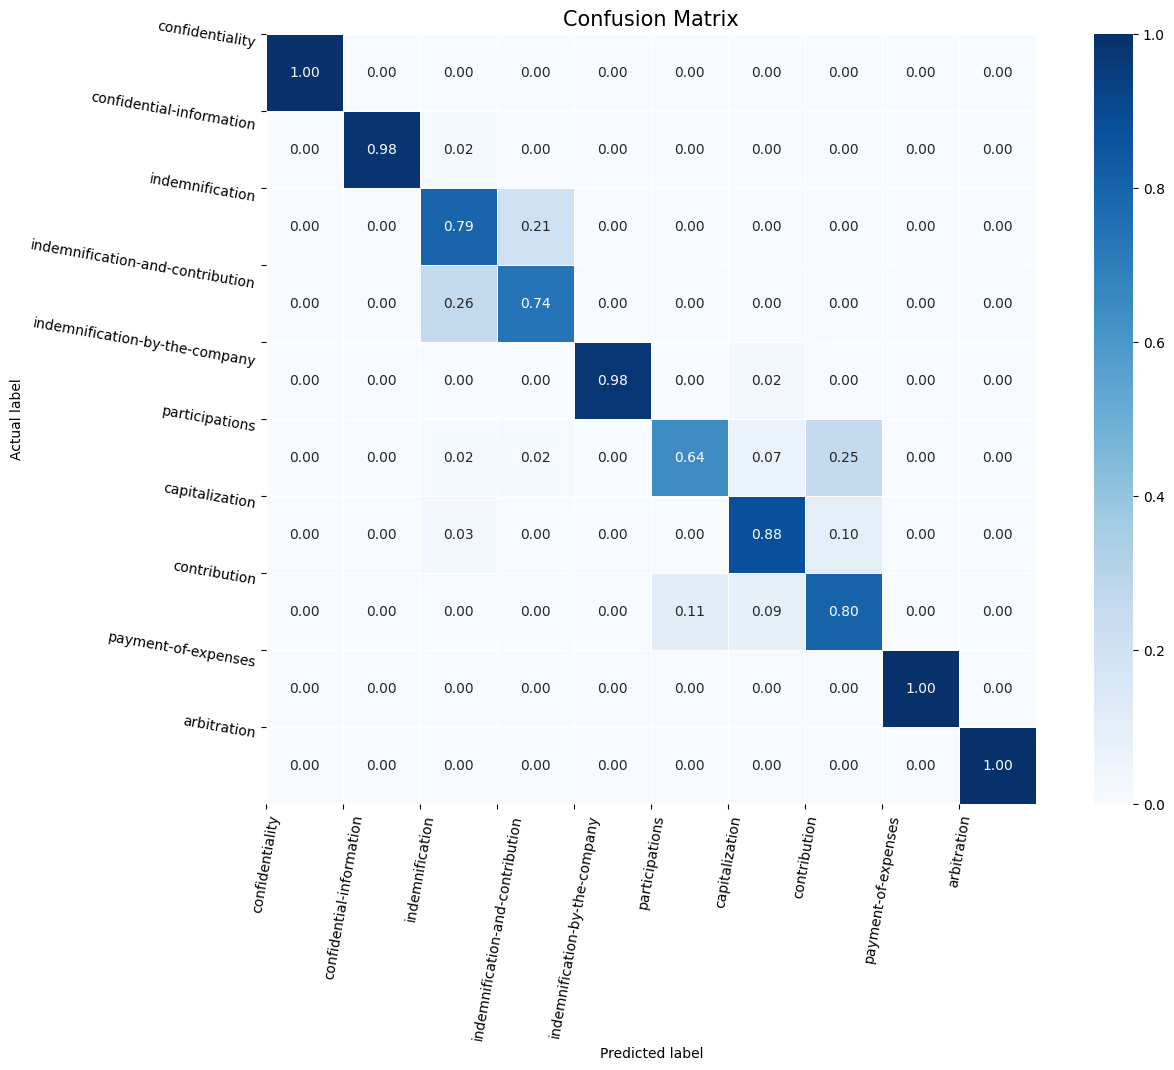

In [117]:
# Creating a reverse dictionary for labels which
label_dict_inverse = {v: k for k, v in label_dict.items()}

# Converting integer labels back to original
original_test_labels = [label_dict_inverse[label] for label in test_labels]
original_predicted_classes = [label_dict_inverse[label] for label in predicted_classes]

def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize it

    # Plot confusion matrix
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.title('Confusion Matrix', size=15);
    plt.xticks(np.arange(len(classes)), classes, rotation=80)
    plt.yticks(np.arange(len(classes)), classes, rotation=-10)

    plt.show()

plot_confusion_matrix(original_test_labels, original_predicted_classes, list(label_dict.keys()))


In [67]:
# Produce graph which looks at accuracy by number of words in clause
# Creating a new DataFrame
test_clauses = pd.DataFrame({
    "Texts": test_texts,
    "True Labels": original_test_labels,
    "Predicted Labels": original_predicted_classes
})

#add whether prediction is correct.
test_clauses['Correct Prediction'] = (test_clauses['True Labels'] == test_clauses['Predicted Labels']).astype(int)
#add word count to each record.  Note this is word count after text preprocessing
test_clauses['word_count'] = test_clauses['Texts'].str.split().str.len()

In [81]:
max_word_count = test_clauses['word_count'].max()
word_counts = []
wc_accuracy = [] 
for x in range(1,max_word_count):
    # Slice the DataFrame
    df_less_than_x = test_clauses[test_clauses['word_count'] <= x]
    if len(df_less_than_x) != 0:    
        # Calculate accuracy
        accuracy = (df_less_than_x['True Labels'] == df_less_than_x['Predicted Labels']).mean()
        word_counts.append(x)
        wc_accuracy.append(accuracy)

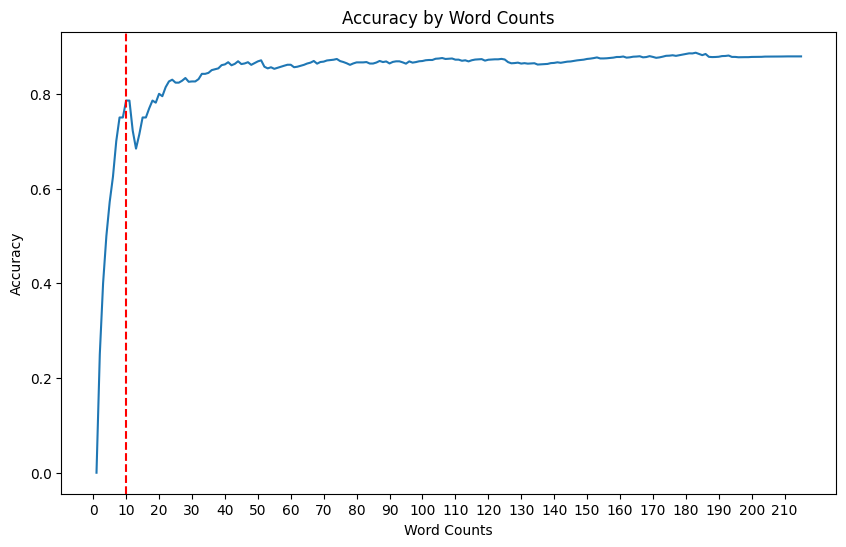

In [101]:
plt.figure(figsize=(10, 6))  # Setting the figure size (optional)
plt.plot(word_counts, wc_accuracy)

# Create xticks at intervals of 10
plt.xticks(np.arange(min(word_counts)-1, max(word_counts), 10))

# Draw a vertical line at word count of 24
plt.axvline(x=10, color='r', linestyle='--')

# Set plot labels and title
plt.xlabel('Word Counts')
plt.ylabel('Accuracy')
plt.title('Accuracy by Word Counts')

# Display the plot
plt.show()


In [102]:
df_more_than_10 = test_clauses[test_clauses['word_count'] >10]
accuracy_10 = (df_more_than_10['True Labels'] == df_more_than_10['Predicted Labels']).mean()
print(accuracy_10)
print(len(test_clauses))
print(len(test_clauses)-len(df_more_than_10))

0.8816793893129771
538
14
